# Assignment 3
In this assignment, you will be coding two new (nn.Module)s that implement a Linear layer and BatchNorm. Then you will use them to train a conv net over multiple datasets.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import tensorflow as tf
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
sns.set_theme(color_codes=True)
import numpy as np
import warnings
import math
warnings.filterwarnings('ignore')

**Datasets**
In this assignment you will only use training sets. Here, I only load CIFAR10, but you should load the following datasets, which you will use later:


*   CIFAR10
*   Fashion-MNIST
*  KMNIST




In [ ]:
def load_data(CIFAR10=False, FashionMNIST=False, KMNIST=False):
  if CIFAR10:
    CIFAR10_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transforms.ToTensor())
    CIFAR10_trainloader = torch.utils.data.DataLoader(CIFAR10_trainset, batch_size=64,
                                          shuffle=True)
    return CIFAR10_trainset,CIFAR10_trainloader
  elif FashionMNIST:
    FashionMNIST_trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                            download=True, transform=transforms.ToTensor())
    FashionMNIST_trainloader = torch.utils.data.DataLoader(FashionMNIST_trainset, batch_size=64,
                                              shuffle=True)
    return FashionMNIST_trainset,FashionMNIST_trainloader
  elif KMNIST:
    KMNIST_trainset = torchvision.datasets.KMNIST(root='./data', train=True,
                                            download=True, transform=transforms.ToTensor())
    KMNIST_trainloader = torch.utils.data.DataLoader(KMNIST_trainset, batch_size=64,
                                              shuffle=True)
    return KMNIST_trainset, KMNIST_trainloader

# Neural net
This is our vanilla CNN for this experiment. The sizes of the Linear layers were designed for CIFAR10, the first dataset you should experiment with. Later, you will have to change those numbers to fit the other datasets.

In [ ]:
class CNN(nn.Module):

    def __init__(self, DropOut=False, DO_Prob=0, Norm=False, notCIFAR=False):
        super(CNN, self).__init__()
        self.is_Norm = Norm
        self.notCIFAR = notCIFAR
        if self.notCIFAR:
          self.conv0 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=1, padding=2)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # now a few fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        if Norm:
            self.Norm = MyBatchNorm(64)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        # For Task 2 we are using Mylinear implemented in Task 1
        if DropOut :
          self.fc1 = MyLinear(16 * 5 * 5, 120,DO_Prob)
          self.fc2 = MyLinear(120, 84,DO_Prob)
          self.fc3 = MyLinear(84, 10,DO_Prob)

    def forward(self, x):
        if self.notCIFAR:
          x = F.max_pool2d(F.relu(self.conv0(x)), 1)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        
        if self.is_Norm:
          x = F.relu(self.Norm(self.fc1(x)))
          
        else:
          x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [ ]:
def train_nn(epoch_num, trainloader, optimizer, criterion):
  train_loss = []
  # training loop
  for epoch in range(epoch_num): 
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          
          # get the inputs
          inputs, labels = data
          inputs = inputs.cuda() # -- For GPU
          labels = labels.cuda() # -- For GPU
          # zero the parameter gradients
          optimizer.zero_grad()
          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          # print statistics
          running_loss += loss.item()
          if (i + 1)  % 200 == 0:   
              train_loss.append(running_loss / 200) 
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 200))
              running_loss = 0.0
  print('Finished Training')
  return train_loss

In [ ]:
CIFAR10_trainset,CIFAR10_trainloader = load_data(CIFAR10=True)

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
net = CNN().cuda()     # -- For GPU
print(net)
# define loss function
criterion = nn.CrossEntropyLoss()
# define the optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss = train_nn(epoch_num=50, trainloader=CIFAR10_trainloader, optimizer=optimizer, criterion=criterion)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[1,   200] loss: 2.306
[1,   400] loss: 2.303
[1,   600] loss: 2.301
[2,   200] loss: 2.294
[2,   400] loss: 2.285
[2,   600] loss: 2.259
[3,   200] loss: 2.106
[3,   400] loss: 2.026
[3,   600] loss: 2.005
[4,   200] loss: 1.951
[4,   400] loss: 1.927
[4,   600] loss: 1.897
[5,   200] loss: 1.803
[5,   400] loss: 1.764
[5,   600] loss: 1.734
[6,   200] loss: 1.663
[6,   400] loss: 1.642
[6,   600] loss: 1.598
[7,   200] loss: 1.580
[7,   400] loss: 1.555
[7,   600] loss: 1.542
[8,   200] loss: 1.506
[8,   400] loss: 1.519
[8,   600] loss: 1.477
[9,   200] loss: 1.468
[9,   400] loss: 1.459
[9,   600] loss: 1.442
[10,   200] loss: 1.421
[10,   400] loss: 1.419
[10,   600] loss: 1.41

# Task 1
Implement a nn.Module that immitates nn.Linear, with additional support for Dropout. In other words, this module should take three arguments: input dimension, output dimension and the keep_prop probability for dropout. Make sure to wrap your parameter tensors with nn.Parameter.

In [ ]:
 class MyLinear(nn.Module):
   def __init__(self, input_dim, output_dim, keep_prob=0.):
     super(MyLinear, self).__init__()
     self.in_features = input_dim
     self.out_features = output_dim
     self.weight = torch.nn.Parameter(torch.randn(input_dim,output_dim)).cuda()
     self.keep_prob = keep_prob
     torch.nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
    
   def forward(self, input):
     delta = torch.Tensor(np.random.binomial(1, self.keep_prob, size=input.shape)).cuda()
     input = torch.mul(input, delta).cuda()
     input = torch.matmul(input, self.weight).cuda()
     return input
    

# Task 2
You should add your new MyLinear Module to our CNN. Simply replace fc1, fc2, and fc3 with your new module, this time with keep_prob=1. Then, train the network over CIFAR10 with and without your Module, and compare the loss curves (plot both of them onto the same figure, with two different colors).



In [ ]:
# You code for Task 2 goes here. Note - you don't have to copy the entire network here, just modify everything in place, run it, and collect the losses. Then, here write your plots.

In [ ]:
# Creating the network 
net = CNN(DropOut=True, DO_Prob=1).cuda()     # -- For GPU
print(net)
# define loss function
criterion = nn.CrossEntropyLoss()
# define the optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss_task2 = train_nn(epoch_num=50, trainloader=CIFAR10_trainloader, optimizer=optimizer, criterion=criterion)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): MyLinear()
  (fc2): MyLinear()
  (fc3): MyLinear()
)
[1,   200] loss: 2.302
[1,   400] loss: 2.300
[1,   600] loss: 2.296
[2,   200] loss: 2.293
[2,   400] loss: 2.290
[2,   600] loss: 2.289
[3,   200] loss: 2.284
[3,   400] loss: 2.282
[3,   600] loss: 2.281
[4,   200] loss: 2.277
[4,   400] loss: 2.275
[4,   600] loss: 2.273
[5,   200] loss: 2.269
[5,   400] loss: 2.265
[5,   600] loss: 2.262
[6,   200] loss: 2.259
[6,   400] loss: 2.251
[6,   600] loss: 2.252
[7,   200] loss: 2.246
[7,   400] loss: 2.244
[7,   600] loss: 2.239
[8,   200] loss: 2.234
[8,   400] loss: 2.232
[8,   600] loss: 2.227
[9,   200] loss: 2.223
[9,   400] loss: 2.218
[9,   600] loss: 2.217
[10,   200] loss: 2.213
[10,   400] loss: 2.213
[10,   600] loss: 2.211
[11,   200] loss: 2.207
[11,   400] loss: 2.206
[11,   600] loss: 2.199
[12,   200] loss: 2.197
[12,   400] loss: 2.195
[

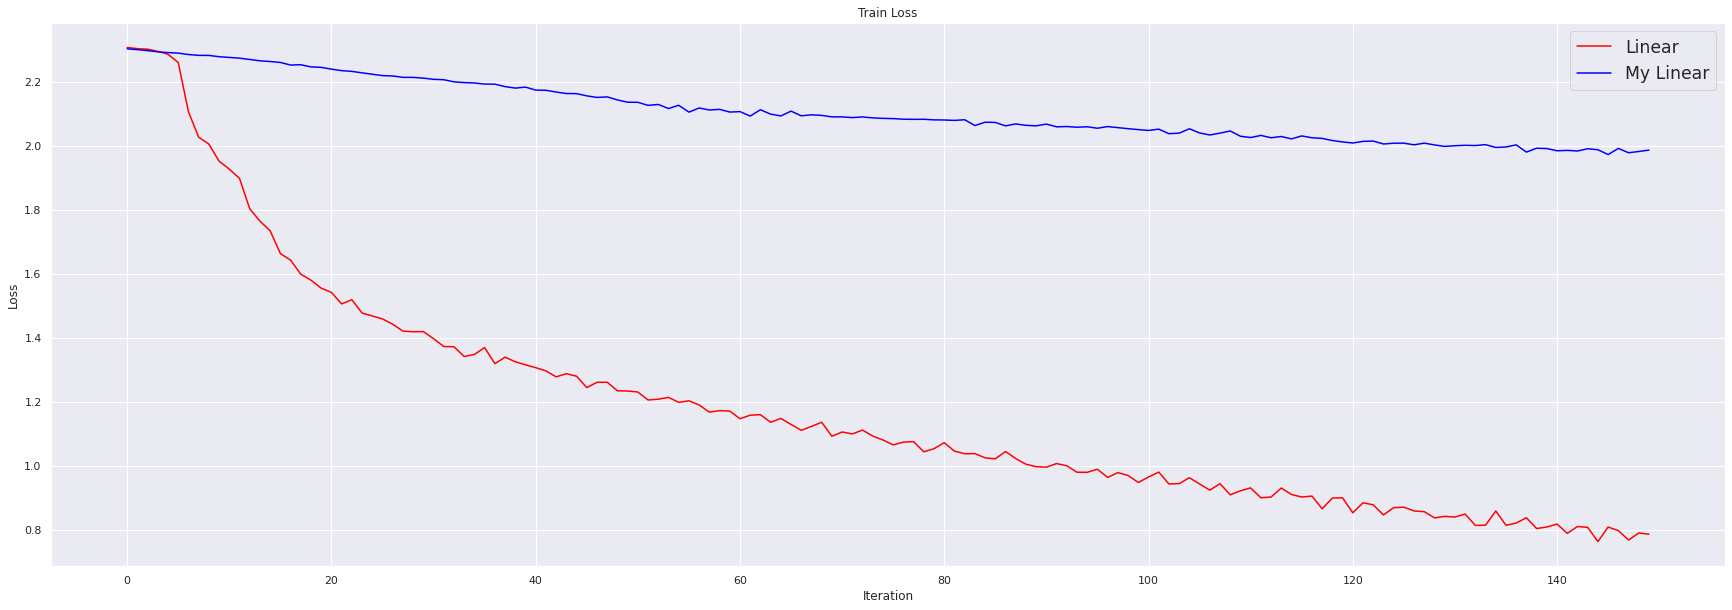

In [ ]:
# Plot the results
fig, axes = plt.subplots(1, 1, figsize=(30.0, 10.0))
sns.lineplot(np.arange(len(loss)), loss,ax=axes, color="red", label="Linear")
sns.lineplot(np.arange(len(loss_task2)), loss_task2,ax=axes, color="blue", label="My Linear")

axes.set_title('Train Loss')
axes.set_xlabel('Iteration')
axes.set_ylabel('Loss')
plt.legend(fontsize='xx-large')
plt.show()

# Task 3

Use your MyLinear module like before, but this time compare the loss curves of two runs: keep_prob = 1 and keep_prob = 0.5.

In [ ]:
# You code for Task 3 goes here. Note - you don't have to copy the entire network here, just modify everything in place, run it, and collect the losses. Then, here write your plots.

In [ ]:
# Creating the network 
net = CNN(DropOut=True, DO_Prob=0.5).cuda()     # -- For GPU
print(net)
# define loss function
criterion = nn.CrossEntropyLoss()
# define the optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss_task3 = train_nn(epoch_num=50, trainloader=CIFAR10_trainloader, optimizer=optimizer, criterion=criterion)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): MyLinear()
  (fc2): MyLinear()
  (fc3): MyLinear()
)
[1,   200] loss: 2.304
[1,   400] loss: 2.302
[1,   600] loss: 2.301
[2,   200] loss: 2.300
[2,   400] loss: 2.299
[2,   600] loss: 2.298
[3,   200] loss: 2.296
[3,   400] loss: 2.292
[3,   600] loss: 2.290
[4,   200] loss: 2.288
[4,   400] loss: 2.287
[4,   600] loss: 2.283
[5,   200] loss: 2.280
[5,   400] loss: 2.278
[5,   600] loss: 2.273
[6,   200] loss: 2.266
[6,   400] loss: 2.264
[6,   600] loss: 2.263
[7,   200] loss: 2.259
[7,   400] loss: 2.256
[7,   600] loss: 2.250
[8,   200] loss: 2.249
[8,   400] loss: 2.248
[8,   600] loss: 2.248
[9,   200] loss: 2.248
[9,   400] loss: 2.242
[9,   600] loss: 2.248
[10,   200] loss: 2.241
[10,   400] loss: 2.243
[10,   600] loss: 2.238
[11,   200] loss: 2.237
[11,   400] loss: 2.243
[11,   600] loss: 2.232
[12,   200] loss: 2.238
[12,   400] loss: 2.242
[

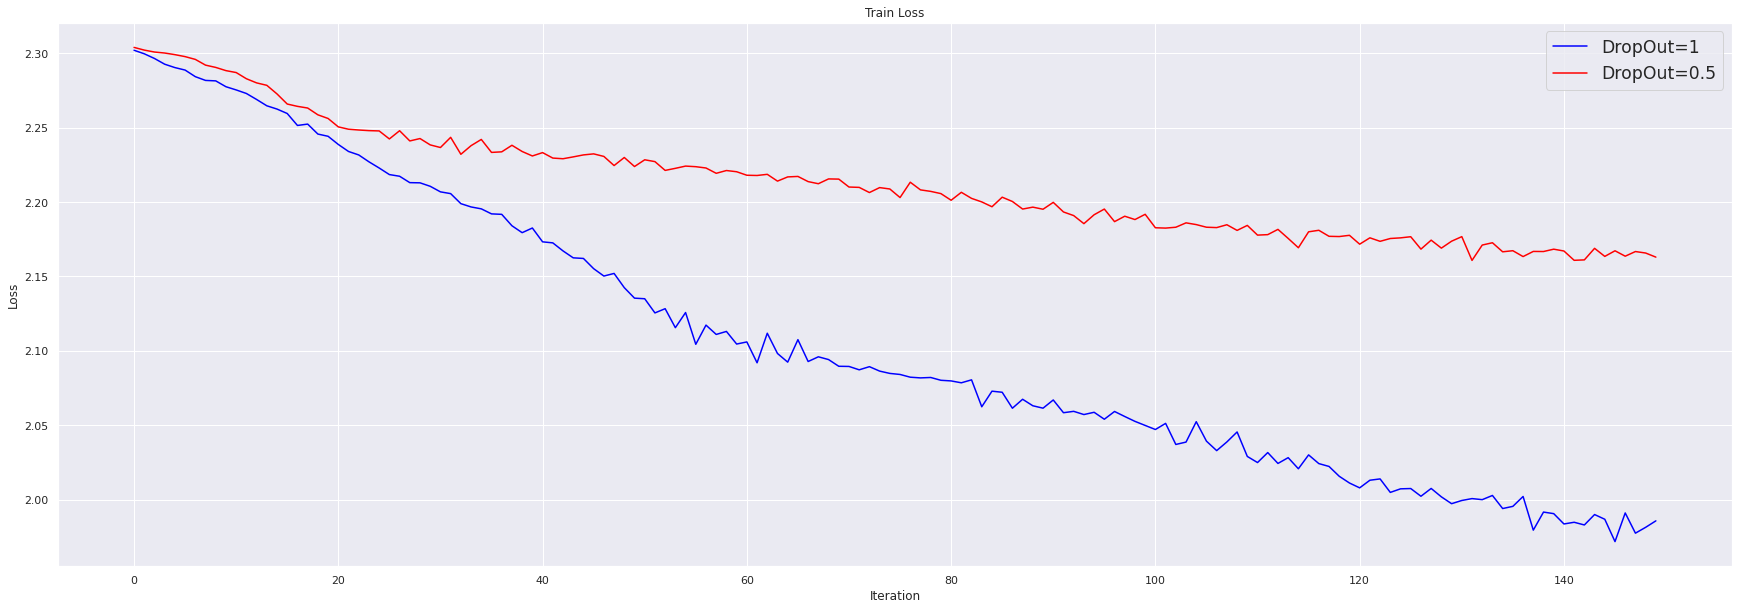

In [ ]:
# Plot the results
fig, axes = plt.subplots(1, 1, figsize=(30.0, 10.0))
sns.lineplot(np.arange(len(loss_task2)), loss_task2,ax=axes, color="blue", label="DropOut=1")
sns.lineplot(np.arange(len(loss_task3)), loss_task3,ax=axes, color="red", label="DropOut=0.5")

axes.set_title('Train Loss')
axes.set_xlabel('Iteration')
axes.set_ylabel('Loss')
plt.legend(fontsize='xx-large')
plt.show()

# Task 4

Implement a Module that performs Batch Normalization for the output of a Linear Module. In a nutshel, in it's forward procedure, this module should standartize the input (assumed to be of the same shape you use with nn.Linear, that is, (N, L) = N is the number of vectors in the batch, and L is the input vector), and then multiply it by gamma and add beta. Gamma and beta should be learnable, i.e., of nn.Parameter type.
Use running average to calculate the relevant information for testing time, and store them accordingly.

In [ ]:
# TODO: Implement the following Module. Size is the length of the input vectors.

class MyBatchNorm(nn.Module):
  def __init__(self, size, epsilon=1e-05):
    super(MyBatchNorm, self).__init__()
    self.size = size
    self.epsilon = epsilon
    self.first = True
    self.prev_gama = None
    self.gama = np.array([])
    
  def forward(self, input):
    if  self.gama.shape[0] != input.shape[0]:
      self.gama = self.prev_gama
    if self.first or self.gama.shape[0] != input.shape[0]:
      self.gama = torch.nn.Parameter(torch.randn(input.shape[0],1)).cuda()
      self.beta = torch.nn.Parameter(torch.randn(input.shape[0],1)).cuda()
      self.first = False
    self.prev_gama = self.gama
    mean = torch.mean(input, axis=0)
    variance = torch.mean((input - mean) ** 2, axis=0)
    # normalize
    input_hat = (input - mean) * 1.0 / torch.sqrt(variance + self.epsilon)
    # scale and shift
    out = torch.mul(self.gama, input_hat) + self.beta
    return out

# Task 5
You should add your new MyBatchNorm Module to our CNN, right after fc1. Then, train the network over CIFAR10 with and without your Module, and compare the loss curves (plot both of them onto the same figure, with two different colors).

In [ ]:
# You code for Task 5 goes here. Note - you don't have to copy the entire network here, just modify everything in place, run it, and collect the losses. Then, here write your plots.

In [ ]:
# Creating the network 
net = CNN(Norm=True).cuda()     # -- For GPU
print(net)
# define loss function
criterion = nn.CrossEntropyLoss()
# define the optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss_task5 = train_nn(epoch_num=50, trainloader=CIFAR10_trainloader, optimizer=optimizer, criterion=criterion)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (Norm): MyBatchNorm()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[1,   200] loss: 2.311
[1,   400] loss: 2.296
[1,   600] loss: 2.287
[2,   200] loss: 2.274
[2,   400] loss: 2.259
[2,   600] loss: 2.246
[3,   200] loss: 2.243
[3,   400] loss: 2.234
[3,   600] loss: 2.224
[4,   200] loss: 2.198
[4,   400] loss: 2.176
[4,   600] loss: 2.165
[5,   200] loss: 2.157
[5,   400] loss: 2.139
[5,   600] loss: 2.125
[6,   200] loss: 2.123
[6,   400] loss: 2.108
[6,   600] loss: 2.106
[7,   200] loss: 2.068
[7,   400] loss: 2.062
[7,   600] loss: 2.051
[8,   200] loss: 2.051
[8,   400] loss: 2.027
[8,   600] loss: 2.024
[9,   200] loss: 1.971
[9,   400] loss: 1.951
[9,   600] loss: 1.941
[10,   200] loss: 1.950
[10,   400] loss: 1.93

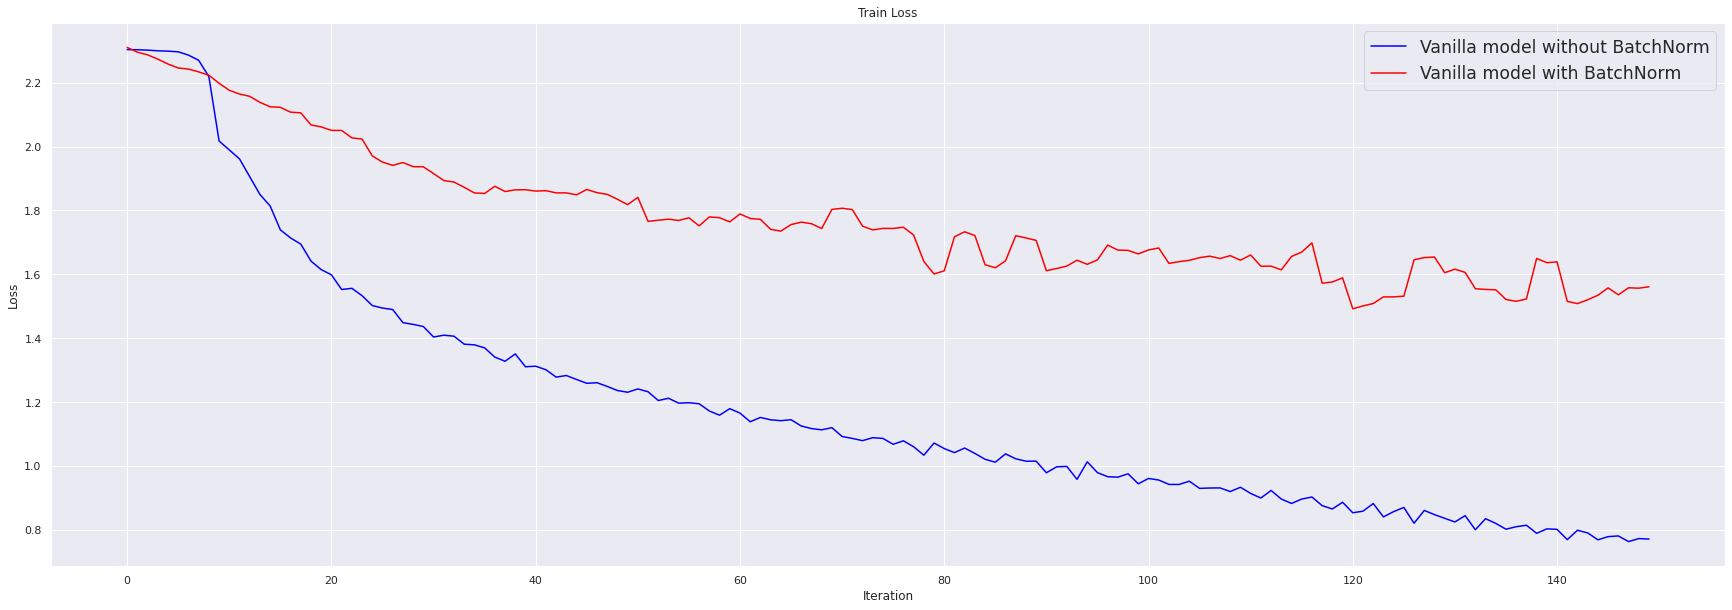

In [ ]:
# Plot the results
fig, axes = plt.subplots(1, 1, figsize=(30.0, 10.0))
sns.lineplot(np.arange(len(loss)), loss,ax=axes, color="blue", label="Vanilla model without BatchNorm")
sns.lineplot(np.arange(len(loss_task5)), loss_task5,ax=axes, color="red", label="Vanilla model with BatchNorm")

axes.set_title('Train Loss')
axes.set_xlabel('Iteration')
axes.set_ylabel('Loss')
plt.legend(fontsize='xx-large')
plt.show()

# Task 6
Run your network over all training sets, with and without batch norm, as designed in Task 4 and 5.
Present 6 curves, two for each dataset.

In [ ]:
# You code for Task 6 goes here. Note - you don't have to copy the entire network here, just modify everything in place, run it, and collect the losses. Then, here write your plots.

##### CIFAR10 DATA:

In [ ]:
# Load the dataset
CIFAR10_trainset,CIFAR10_trainloader = load_data(CIFAR10=True)
CIFAR10_trainset[0][0].shape

Files already downloaded and verified


torch.Size([3, 32, 32])

In [ ]:
# Creating the network 
net = CNN(Norm=True).cuda()     # -- For GPU
print(net)
# define loss function
criterion = nn.CrossEntropyLoss()
# define the optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss_task6_CIFAR = train_nn(epoch_num=50, trainloader=CIFAR10_trainloader, optimizer=optimizer, criterion=criterion)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (Norm): MyBatchNorm()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[1,   200] loss: 2.311
[1,   400] loss: 2.303
[1,   600] loss: 2.297
[2,   200] loss: 2.279
[2,   400] loss: 2.265
[2,   600] loss: 2.255
[3,   200] loss: 2.240
[3,   400] loss: 2.224
[3,   600] loss: 2.208
[4,   200] loss: 2.206
[4,   400] loss: 2.191
[4,   600] loss: 2.181
[5,   200] loss: 2.177
[5,   400] loss: 2.166
[5,   600] loss: 2.147
[6,   200] loss: 2.141
[6,   400] loss: 2.127
[6,   600] loss: 2.132
[7,   200] loss: 2.100
[7,   400] loss: 2.084
[7,   600] loss: 2.086
[8,   200] loss: 2.055
[8,   400] loss: 2.049
[8,   600] loss: 2.037
[9,   200] loss: 2.047
[9,   400] loss: 2.039
[9,   600] loss: 2.032
[10,   200] loss: 1.969
[10,   400] loss: 1.95

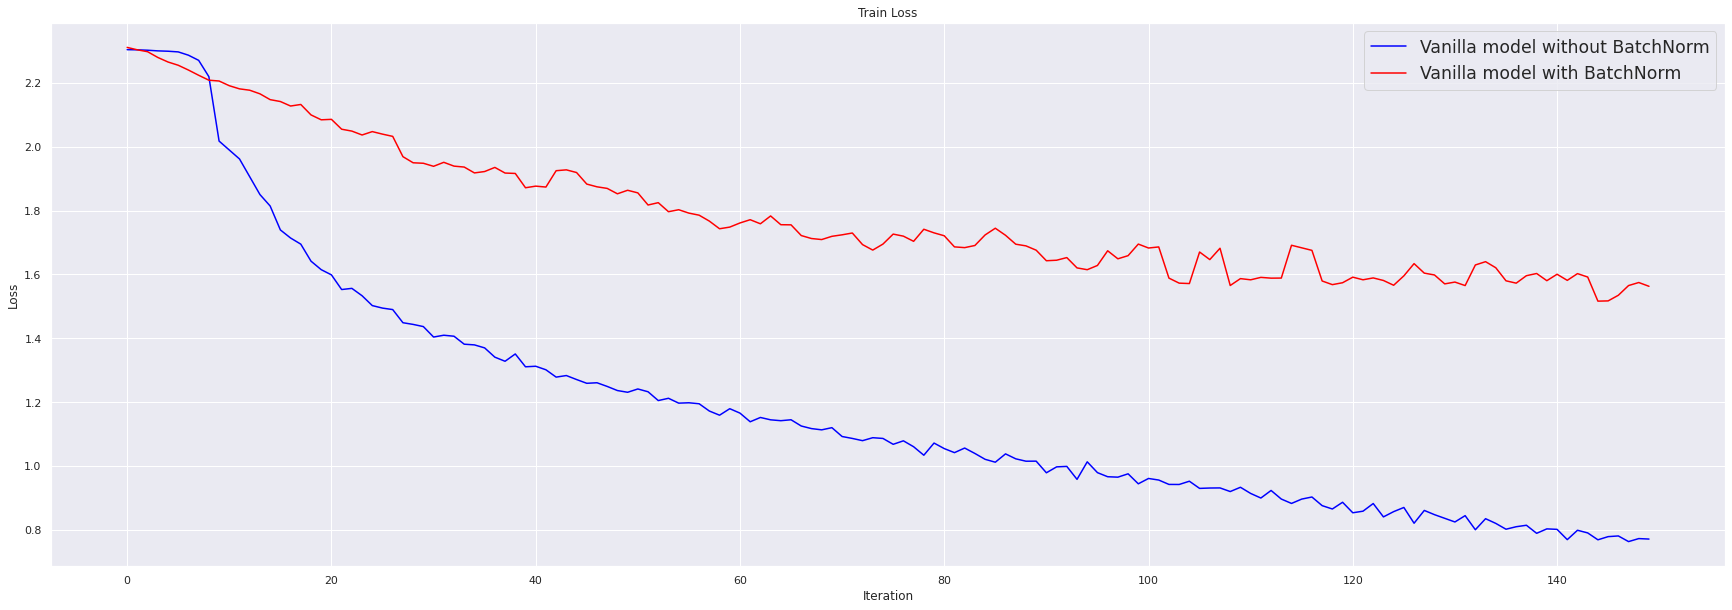

In [ ]:
# Plot the results
fig, axes = plt.subplots(1, 1, figsize=(30.0, 10.0))
sns.lineplot(np.arange(len(loss)), loss,ax=axes, color="blue", label="Vanilla model without BatchNorm")
sns.lineplot(np.arange(len(loss_task6_CIFAR)), loss_task6_CIFAR,ax=axes, color="red", label="Vanilla model with BatchNorm")

axes.set_title('Train Loss')
axes.set_xlabel('Iteration')
axes.set_ylabel('Loss')
plt.legend(fontsize='xx-large')
plt.show()

##### FashionMNIST DATA:

In [ ]:
# Load the dataset
FashionMNIST_trainset,FashionMNIST_trainloader = load_data(FashionMNIST=True)
FashionMNIST_trainset[0][0].shape

torch.Size([1, 28, 28])

###### First we train the Vanilla model with this dataset:

In [ ]:
# Creating the network 
net = CNN(notCIFAR=True).cuda()     # -- For GPU
print(net)
# define loss function
criterion = nn.CrossEntropyLoss()
# define the optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss_FSHN_VIN = train_nn(epoch_num=50, trainloader=FashionMNIST_trainloader, optimizer=optimizer, criterion=criterion)

CNN(
  (conv0): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[1,   200] loss: 2.304
[1,   400] loss: 2.302
[1,   600] loss: 2.300
[1,   800] loss: 2.298
[2,   200] loss: 2.290
[2,   400] loss: 2.268
[2,   600] loss: 2.043
[2,   800] loss: 1.071
[3,   200] loss: 0.752
[3,   400] loss: 0.674
[3,   600] loss: 0.673
[3,   800] loss: 0.631
[4,   200] loss: 0.611
[4,   400] loss: 0.597
[4,   600] loss: 0.579
[4,   800] loss: 0.573
[5,   200] loss: 0.543
[5,   400] loss: 0.527
[5,   600] loss: 0.528
[5,   800] loss: 0.529
[6,   200] loss: 0.520
[6,   400] loss: 0.495
[6,   600] loss: 0.472
[6,   800] loss: 0.496
[7,   200] loss: 0.482
[7,   400] loss: 0.460
[7,   600] loss: 0

###### Now we train with BatchNorm:

In [ ]:
net = CNN(Norm=True, notCIFAR=True).cuda()     # -- For GPU
print(net)
# define loss function
criterion = nn.CrossEntropyLoss()
# define the optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss_FSHN_NORM = train_nn(epoch_num=50, trainloader=FashionMNIST_trainloader, optimizer=optimizer, criterion=criterion)

CNN(
  (conv0): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (Norm): MyBatchNorm()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[1,   200] loss: 2.232
[1,   400] loss: 2.103
[1,   600] loss: 1.987
[1,   800] loss: 1.863
[2,   200] loss: 1.791
[2,   400] loss: 1.722
[2,   600] loss: 1.660
[2,   800] loss: 1.591
[3,   200] loss: 1.411
[3,   400] loss: 1.361
[3,   600] loss: 1.318
[3,   800] loss: 1.282
[4,   200] loss: 1.241
[4,   400] loss: 1.223
[4,   600] loss: 1.189
[4,   800] loss: 1.171
[5,   200] loss: 1.283
[5,   400] loss: 1.270
[5,   600] loss: 1.247
[5,   800] loss: 1.236
[6,   200] loss: 0.914
[6,   400] loss: 0.914
[6,   600] loss: 0.892
[6,   800] loss: 0.878
[7,   200] loss: 0.932
[7,   400] loss: 

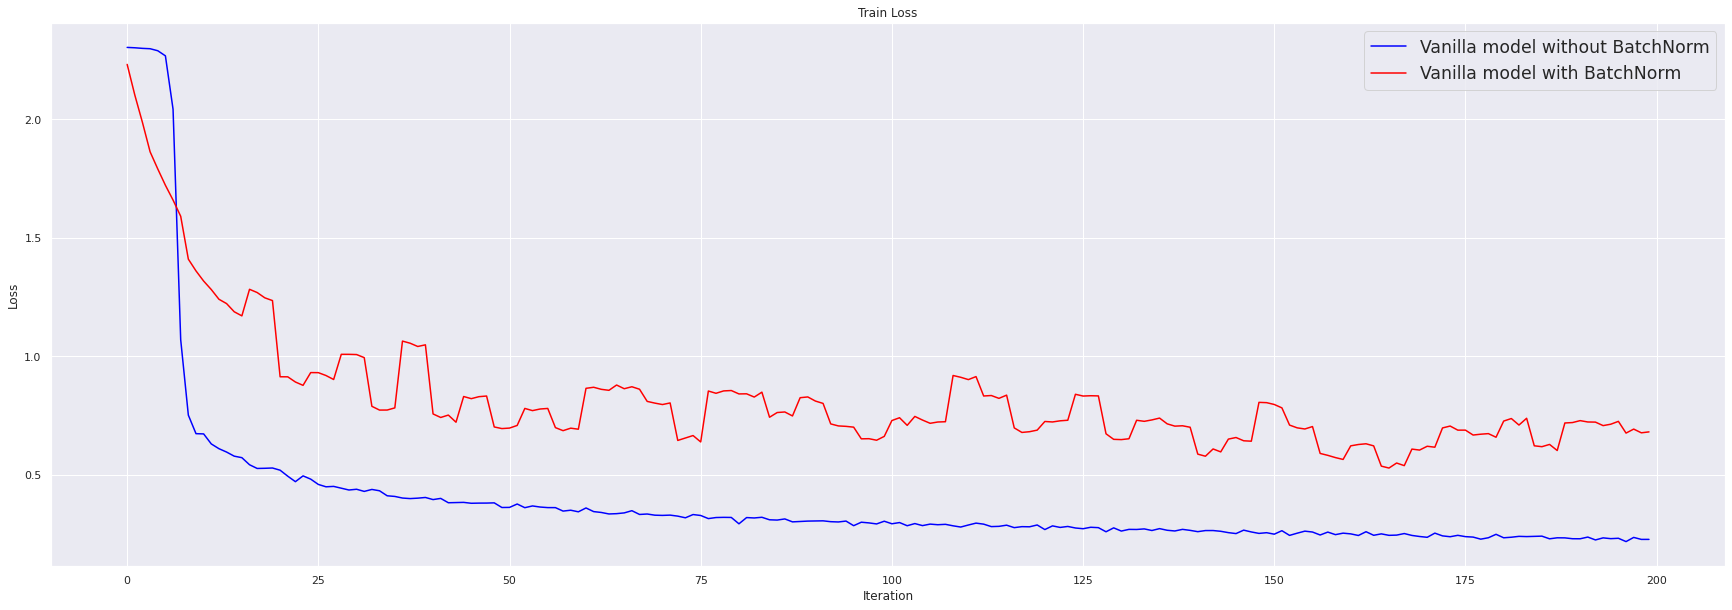

In [ ]:
# Plot the results
fig, axes = plt.subplots(1, 1, figsize=(30.0, 10.0))
sns.lineplot(np.arange(len(loss_FSHN_VIN)), loss_FSHN_VIN,ax=axes, color="blue", label="Vanilla model without BatchNorm")
sns.lineplot(np.arange(len(loss_FSHN_NORM)), loss_FSHN_NORM,ax=axes, color="red", label="Vanilla model with BatchNorm")

axes.set_title('Train Loss')
axes.set_xlabel('Iteration')
axes.set_ylabel('Loss')
plt.legend(fontsize='xx-large')
plt.show()

##### KMNIST DATA:

In [ ]:
# Load the dataset
KMNIST_trainset,KMNIST_trainloader = load_data(KMNIST=True)
KMNIST_trainset[0][0].shape

torch.Size([1, 28, 28])

###### First we train the Vanilla model with this dataset:

In [ ]:
# Creating the network 
net = CNN(notCIFAR=True).cuda()     # -- For GPU
print(net)
# define loss function
criterion = nn.CrossEntropyLoss()
# define the optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss_MNIST_VIN = train_nn(epoch_num=50, trainloader=KMNIST_trainloader, optimizer=optimizer, criterion=criterion)

CNN(
  (conv0): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[1,   200] loss: 2.304
[1,   400] loss: 2.303
[1,   600] loss: 2.302
[1,   800] loss: 2.300
[2,   200] loss: 2.294
[2,   400] loss: 2.281
[2,   600] loss: 2.199
[2,   800] loss: 1.556
[3,   200] loss: 0.841
[3,   400] loss: 0.703
[3,   600] loss: 0.593
[3,   800] loss: 0.518
[4,   200] loss: 0.436
[4,   400] loss: 0.418
[4,   600] loss: 0.372
[4,   800] loss: 0.358
[5,   200] loss: 0.321
[5,   400] loss: 0.286
[5,   600] loss: 0.270
[5,   800] loss: 0.283
[6,   200] loss: 0.241
[6,   400] loss: 0.229
[6,   600] loss: 0.233
[6,   800] loss: 0.209
[7,   200] loss: 0.194
[7,   400] loss: 0.182
[7,   600] loss: 0

###### Now we train with BatchNorm:

In [ ]:
net = CNN(Norm=True, notCIFAR=True).cuda()     # -- For GPU
print(net)
# define loss function
criterion = nn.CrossEntropyLoss()
# define the optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss_MNIST_NORM = train_nn(epoch_num=50, trainloader=KMNIST_trainloader, optimizer=optimizer, criterion=criterion)

CNN(
  (conv0): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (Norm): MyBatchNorm()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[1,   200] loss: 2.304
[1,   400] loss: 2.286
[1,   600] loss: 2.246
[1,   800] loss: 2.196
[2,   200] loss: 2.028
[2,   400] loss: 1.934
[2,   600] loss: 1.850
[2,   800] loss: 1.765
[3,   200] loss: 1.655
[3,   400] loss: 1.597
[3,   600] loss: 1.525
[3,   800] loss: 1.466
[4,   200] loss: 1.491
[4,   400] loss: 1.450
[4,   600] loss: 1.417
[4,   800] loss: 1.376
[5,   200] loss: 1.220
[5,   400] loss: 1.192
[5,   600] loss: 1.152
[5,   800] loss: 1.114
[6,   200] loss: 1.073
[6,   400] loss: 1.035
[6,   600] loss: 1.016
[6,   800] loss: 0.997
[7,   200] loss: 1.051
[7,   400] loss: 

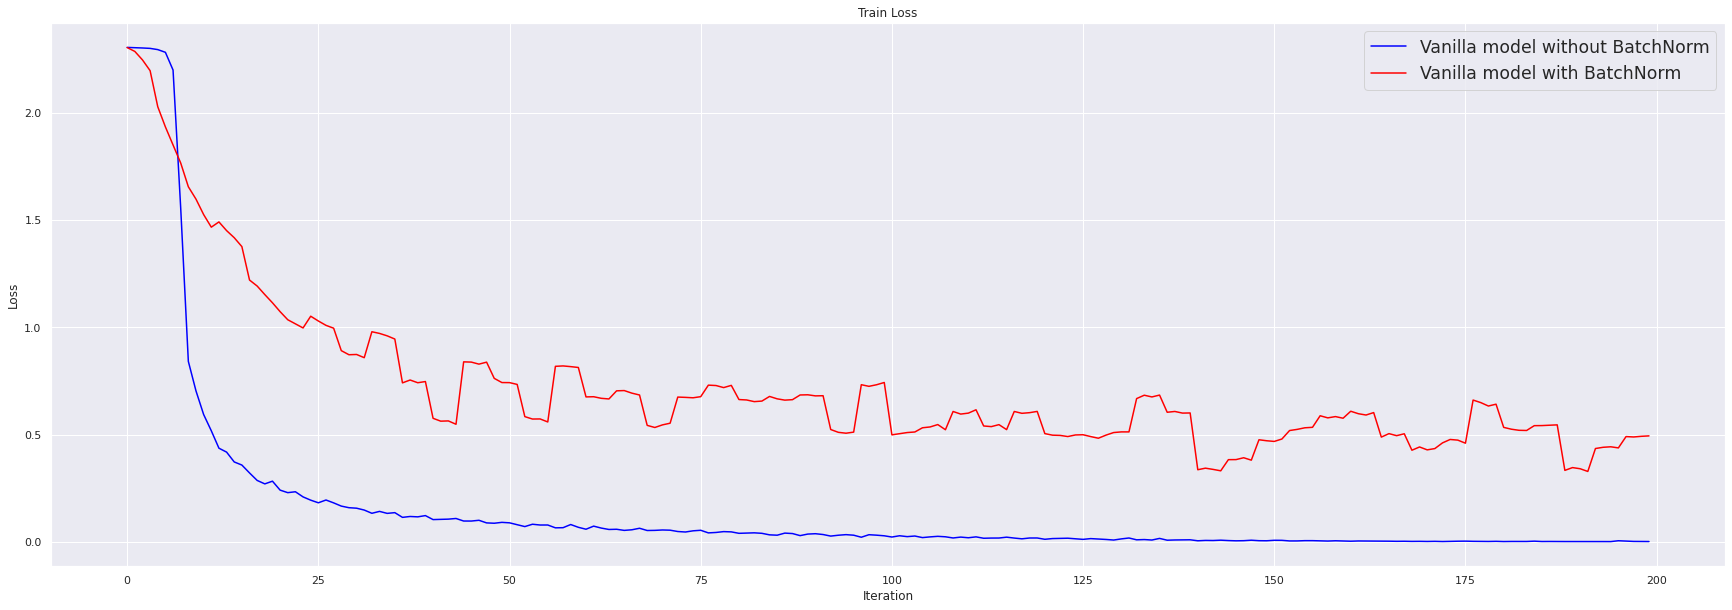

In [ ]:
# Plot the results
fig, axes = plt.subplots(1, 1, figsize=(30.0, 10.0))
sns.lineplot(np.arange(len(loss_MNIST_VIN)), loss_MNIST_VIN,ax=axes, color="blue", label="Vanilla model without BatchNorm")
sns.lineplot(np.arange(len(loss_MNIST_NORM)), loss_MNIST_NORM,ax=axes, color="red", label="Vanilla model with BatchNorm")

axes.set_title('Train Loss')
axes.set_xlabel('Iteration')
axes.set_ylabel('Loss')
plt.legend(fontsize='xx-large')
plt.show()

### End of Assignment